In [1]:
import os
import rasterio
from rasterio.warp import reproject, calculate_default_transform
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp2d
from rasterio.enums import Resampling
from rasterio.plot import show
from scipy.interpolate import griddata
from rasterio.warp import reproject, Resampling

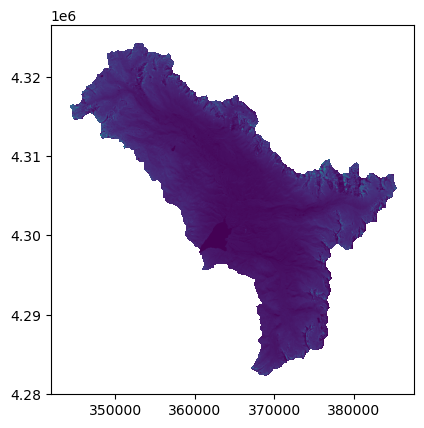

In [4]:
'''
Display ASO raster to be resampled to 1km resolution to match SNODAS
'''

# Path to the raster file you wish to display
raster_filepath = 'ASO_SWE_Data/ASO_50M_SWE_USCOGT_20190408.tif'

# Open the raster file
with rasterio.open(raster_filepath) as src:
    # Display the raster
    show(src, cmap='viridis')


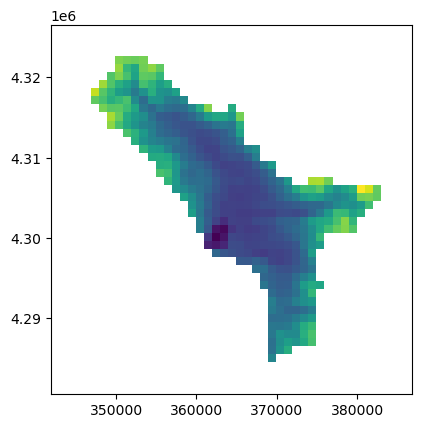

In [6]:
'''
Resample ASO raster to 1km 
'''

def resample_raster(input_filepath, output_filepath, target_resolution):
    """
    Resamples a raster to a new resolution.

    Parameters:
        input_filepath (str): Filepath of the input raster.
        output_filepath (str): Filepath to save the resampled raster.
        target_resolution (float): Target resolution in meters.
    """
    # Open the input raster
    with rasterio.open(input_filepath) as src:
        # Resample the raster to the target resolution
        data = src.read(
            out_shape=(
                src.count,
                int(src.height * src.transform.a / target_resolution),
                int(-1*src.width * src.transform.e / target_resolution)
            ),
            resampling=Resampling.bilinear
        )

        # Update metadata for the resampled raster
        profile = src.profile
        profile.update(
            transform=rasterio.Affine(target_resolution, 0, src.transform.c,
                                      0, -target_resolution, src.transform.f),
            width=data.shape[2],
            height=data.shape[1]
        )

        # Save the resampled raster
        with rasterio.open(output_filepath, 'w', **profile) as dst:
            dst.write(data)

    # Open the resampled raster and display it
    with rasterio.open(output_filepath) as resampled_src:
        show(resampled_src, cmap='viridis')

# Example usage:
# Path to the raster you wish to change the resolution of.
input_filepath = 'ASO_SWE_Data/ASO_50M_SWE_USCOGT_20190408.tif'
output_filepath = 'Reproj_rasters_asocomp/ASO_USCOGT_20190408_resampled_raster.tif' #name you desired resampled ASO raster.
# Target resolution you would like (meters)
target_resolution = 1000  # 1 km resolution in meters

resample_raster(input_filepath, output_filepath, target_resolution)


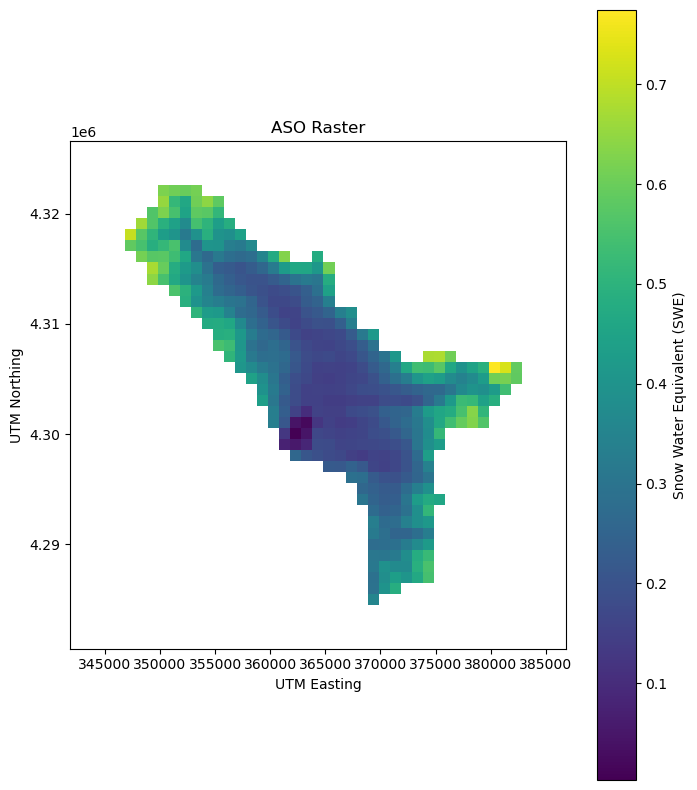

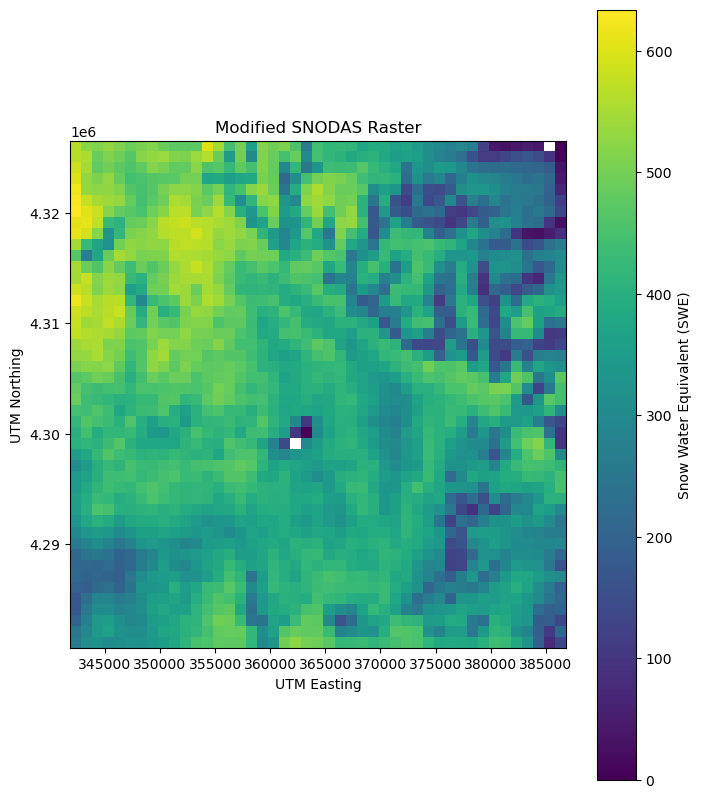

In [7]:
'''
Presenting ASO and SNODAS rasters in the same extent and projection
'''
#Path to the first raster (in UTM)
aso_raster_path = 'Reproj_rasters_asocomp/ASO_USCOGT_20190408_resampled_raster.tif'  # Update this with the path to your UTM ASO raster

# Path to the second raster
snodas_raster_path = 'SNODAS_tiffs/2019/Apr/us_swe_20190408_.tif'  # Update this with the path to your second (SNODAS) raster

figsize=(8,10)

# Plot ASO Raster
with rasterio.open(aso_raster_path) as aso_src:
    aso_data = aso_src.read(1)
    aso_extent = rasterio.plot.plotting_extent(aso_src)
    aso_data_masked = np.where(aso_data == -9999, np.nan, aso_data)  # Mask -9999 values
    plt.figure(figsize=figsize)
    plt.imshow(aso_data_masked, cmap='viridis', extent=aso_extent)
    plt.colorbar(label='Snow Water Equivalent (SWE)')
    plt.title('ASO Raster')
    plt.xlabel('UTM Easting')
    plt.ylabel('UTM Northing')
    plt.show()

# Plot Modified SNODAS Raster
with rasterio.open(snodas_raster_path) as snodas_src:
    # Mask -9999 values
    snodas_data = snodas_src.read(1)
    snodas_data_masked = np.where(snodas_data == -9999, np.nan, snodas_data)
    
    # Get CRS and transform information from ASO raster
    aso_crs = aso_src.crs
    aso_transform = aso_src.transform
    
    # Reproject SNODAS raster to match ASO raster
    reprojected_data = np.empty((aso_src.height, aso_src.width), dtype=aso_src.dtypes[0])
    reproject(
        source=rasterio.band(snodas_src, 1),
        destination=reprojected_data,
        src_transform=snodas_src.transform,
        src_crs=snodas_src.crs,
        dst_transform=aso_transform,
        dst_crs=aso_crs,
        resampling=Resampling.bilinear
    )
    
    # Mask -9999 values in reprojected data
    reprojected_data_masked = np.where(reprojected_data == -9999, np.nan, reprojected_data)
    
    # Plot Modified SNODAS Raster
    plt.figure(figsize=figsize)
    plt.imshow(reprojected_data_masked, cmap='viridis', extent=aso_extent)
    plt.colorbar(label='Snow Water Equivalent (SWE)')
    plt.title('Modified SNODAS Raster')
    plt.xlabel('UTM Easting')
    plt.ylabel('UTM Northing')
    plt.show()

    # Save Modified SNODAS Raster
    output_snodas_path = 'Reproj_rasters_asocomp/Snodas_USCOGT_20190408_clipped.tif'  # Define output filepath
    with rasterio.open(
            output_snodas_path,
            'w',
            driver='GTiff',
            height=reprojected_data.shape[0],
            width=reprojected_data.shape[1],
            count=1,
            dtype=reprojected_data.dtype,
            crs=aso_crs,
            transform=aso_transform,
    ) as dst:
        dst.write(reprojected_data, 1)


In [8]:
'''
function to find bounding box of aso raster. Needed for csv construction and meshgrid
'''

##function to find bounding box of your aso raster of interest. 
def print_raster_bbox(raster_path):
    with rasterio.open(raster_path) as src:
        bbox = src.bounds
        print("Bounding Box of the Raster:")
        print(f"Min X: {bbox.left}")
        print(f"Min Y: {bbox.bottom}")
        print(f"Max X: {bbox.right}")
        print(f"Max Y: {bbox.top}")

# Path to the ASO raster
aso_raster_path = 'Reproj_rasters_asocomp/ASO_USCOGT_20190408_resampled_raster.tif'

# Print the bounding box of the ASO raster
print_raster_bbox(aso_raster_path)


Bounding Box of the Raster:
Min X: 341859.0
Min Y: 4280546.0
Max X: 386859.0
Max Y: 4326546.0


In [9]:
'''
Creating csv of ASO values for the observed values
'''

def raster_to_csv(raster_path, output_csv, bbox):
    with rasterio.open(raster_path) as src:
        # Get the transformation matrix
        transform = src.transform
        
        # Convert latitude and longitude coordinates to pixel coordinates
        min_lon, min_lat, max_lon, max_lat = bbox
        min_col, min_row = ~transform * (min_lon, min_lat)  # Apply the inverse transformation
        max_col, max_row = ~transform * (max_lon, max_lat)
        
        # Round pixel indices to nearest integer
        min_row, max_row, min_col, max_col = int(round(min_row)), int(round(max_row)), int(round(min_col)), int(round(max_col))

        # Ensure min_row and max_row are in the correct order
        min_row, max_row = min(min_row, max_row), max(min_row, max_row)
        min_col, max_col = min(min_col, max_col), max(min_col, max_col)
        
        # Read the raster data for the portion within the bounding box
        portion = src.read(1, window=((min_row, max_row), (min_col, max_col)))
        
        # Get the latitude and longitude values for each pixel within the bounding box
        rows, cols = np.indices(portion.shape)
        latitudes, longitudes = src.xy(min_row + rows, min_col + cols)

        # Apply mask to filter out NoData values (-9999)
        portion = np.where(portion == -9999, np.nan, portion)
        
        # Flatten the arrays
        latitudes_flat = np.array(latitudes).flatten()
        longitudes_flat = np.array(longitudes).flatten()
        portion_flat = portion.flatten()

        # Create DataFrame with Latitude, Longitude, and Raster Value columns
        data = {'Latitude': latitudes_flat,
                'Longitude': longitudes_flat,
                'Raster_Value': portion_flat}
        df = pd.DataFrame(data)
        
        # Save DataFrame to CSV
        df.to_csv(output_csv, index=False)

# Provide the bounding box for the ASO raster
# This should be the bounding box from the previous block
bbox_aso = (341859.0, 4280546.0, 386859.0, 4326546.0)
            
# Path to the ASO raster
aso_raster_path = 'Reproj_rasters_asocomp/ASO_USCOGT_20190408_resampled_raster.tif'

# Output CSV file path
output_csv_aso = 'Modeled-vs-Observed-Snow-Depth/ASO_obs/obs_ASO_USCOGT_20190408.csv'

# Convert ASO raster data to CSV
raster_to_csv(aso_raster_path, output_csv_aso, bbox_aso)

print(f"ASO CSV file created: {output_csv_aso}")


ASO CSV file created: Modeled-vs-Observed-Snow-Depth/ASO_obs/obs_ASO_USCOGT_20190408.csv


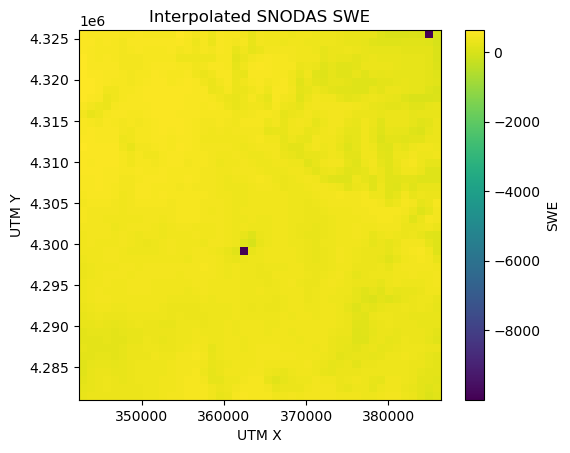

In [10]:
'''
Interpolating SNODAS data onto the ASO grid
'''

# Open the raster files
with rasterio.open('Modeled-vs-Observed-Snow-Depth/Reproj_rasters_asocomp/ASO_USCOGT_20190408_resampled_raster.tif') as src1, rasterio.open('Modeled-vs-Observed-Snow-Depth/Reproj_rasters_asocomp/Snodas_USCOGT_20190408_clipped.tif') as src2:
    # Get the pixel resolution and shape of the ASO raster
    pixel_resolution_aso = src1.res
    rows_aso, cols_aso = src1.shape
    x_min_aso, y_max_aso = src1.bounds.left, src1.bounds.top

    # Calculate the mesh grid for the ASO raster
    x_aso = np.linspace(x_min_aso + pixel_resolution_aso[0] / 2,
                         x_min_aso + pixel_resolution_aso[0] * (cols_aso - 0.5), cols_aso)
    y_aso = np.linspace(y_max_aso - pixel_resolution_aso[1] / 2,
                         y_max_aso - pixel_resolution_aso[1] * (rows_aso - 0.5), rows_aso)
    xx_aso, yy_aso = np.meshgrid(x_aso, y_aso)

    # Get the pixel resolution and shape of the SNODAS raster
    pixel_resolution_snodas = src2.res
    rows_snodas, cols_snodas = src2.shape
    x_min_snodas, y_max_snodas = src2.bounds.left, src2.bounds.top

    # Calculate the mesh grid for the SNODAS raster
    x_snodas = np.linspace(x_min_snodas + pixel_resolution_snodas[0] / 2,
                            x_min_snodas + pixel_resolution_snodas[0] * (cols_snodas - 0.5), cols_snodas)
    y_snodas = np.linspace(y_max_snodas - pixel_resolution_snodas[1] / 2,
                            y_max_snodas - pixel_resolution_snodas[1] * (rows_snodas - 0.5), rows_snodas)
    xx_snodas, yy_snodas = np.meshgrid(x_snodas, y_snodas)

    # Read the SNODAS raster data
    data_values_snodas = src2.read(1)

    # Interpolate SNODAS raster onto the meshgrid of ASO raster
    interpolated_data_snodas = griddata((xx_snodas.flatten(), yy_snodas.flatten()),
                                        data_values_snodas.flatten(), (xx_aso, yy_aso), method='linear')

    # Flip the raster values upside down
    interpolated_data_snodas_flipped = np.flipud(interpolated_data_snodas)
    
    # Plot the flipped interpolated SNODAS data
    plt.imshow(interpolated_data_snodas_flipped, extent=(x_aso.min(), x_aso.max(), y_aso.min(), y_aso.max()), origin='lower')
    plt.colorbar(label='SWE')
    plt.xlabel('UTM X')
    plt.ylabel('UTM Y')
    plt.title('Interpolated SNODAS SWE')
    plt.show()

    
    # Save UTM coordinates and SNODAS SWE values into a CSV file
    df_snodas = pd.DataFrame({'UTM_X': xx_aso.flatten(), 'UTM_Y': yy_aso.flatten(),
                               'SNODAS_SWE': interpolated_data_snodas.flatten()})
    df_snodas.to_csv('SNODAS_USCOGT_20190408.csv', index=False)


In [11]:
import pandas as pd

# Read the first CSV file into a pandas DataFrame to find missing values
csv_file_path_1 = 'Modeled-vs-Observed-Snow-Depth/ASO_obs/obs_ASO_USCOGT_20190408.csv'  # Replace 'first_csv_file.csv' with the path to your ASO CSV file
df1 = pd.read_csv(csv_file_path_1)

# Specify the column name where you found missing values
column_name = 'Raster_Value'  # Replace 'your_column_name' with the actual column name, usually 'Raster_Value'

# Get the indices of rows where the specified column has missing values
missing_indices = df1[df1[column_name].isnull()].index

# Drop rows from the first DataFrame at the indices where missing values were found
df1_cleaned = df1.drop(missing_indices)

# Read the second CSV file into a pandas DataFrame
csv_file_path_2 = 'SNODAS_USCOGT_20190408.csv'  # Replace 'second_csv_file.csv' with the actual path to your second CSV file
df2 = pd.read_csv(csv_file_path_2)

# Drop rows from the second DataFrame at the indices found in the first DataFrame
df2_cleaned = df2.drop(missing_indices)

# Write the cleaned DataFrames to new CSV files
output_csv_path_1 = 'Modeled-vs-Observed-Snow-Depth/ASO_obs/obs_ASO_USCOGT_20190408.csv'  # Specify the path for the cleaned first CSV file
output_csv_path_2 = 'Modeled-vs-Observed-Snow-Depth/SNODAS_pred/pred_SNODAS_USCOGT_20190408.csv'  # Specify the path for the cleaned second CSV file
df1_cleaned.to_csv(output_csv_path_1, index=False)
df2_cleaned.to_csv(output_csv_path_2, index=False)

print("Rows with missing values removed from both CSV files.")
print("Cleaned first CSV file saved to '{}'.".format(output_csv_path_1))
print("Cleaned second CSV file saved to '{}'.".format(output_csv_path_2))


Rows with missing values removed from both CSV files.
Cleaned first CSV file saved to 'Modeled-vs-Observed-Snow-Depth/ASO_obs/obs_ASO_USCOGT_20190408.csv'.
Cleaned second CSV file saved to 'Modeled-vs-Observed-Snow-Depth/SNODAS_pred/pred_SNODAS_USCOGT_20190408.csv'.
